## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*
6.   *model_train_test.py*

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network.py
Saving ccm_pruner.py to ccm_pruner.py
Saving dataloader.py to dataloader.py
Saving model_train_test.py to model_train_test.py
Saving requirements.txt to requirements.txt
Saving utils.py to utils.py
User uploaded file "capsule_network.py"
User uploaded file "ccm_pruner.py"
User uploaded file "dataloader.py"
User uploaded file "model_train_test.py"
User uploaded file "requirements.txt"
User uploaded file "utils.py"


In [ ]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/"

Mounted at /content/drive


Importing required libraries

In [ ]:
import os, gc
import shutil
import time, datetime
from thop import profile, clever_format
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

import capsule_network as caps
import ccm_pruner as ccmp
import model_train_test as mtt
import utils
from dataloader import image_dataloader

CapsuleNet is using device: cuda


Device (CPU/GPU) available to use.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.random.manual_seed(random_seed)

This notebook using device: cuda


Setting up logger and directories

In [ ]:
try:
    ROOT
except NameError:
    ROOT="./results/"
    if not os.path.exists(ROOT):
        os.makedirs(ROOT)

print('ROOT Directory:', ROOT)

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"

logger = utils.get_logger(LOG_DIR)

ROOT Directory: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/


In [ ]:
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
assert False, "Stop execution of next cell!"

AssertionError: Stop execution of next cell!

## Single Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

batch_size=32
n_epochs=15
n_caps_layers=10

n_class=10
prim_caps_channels=16
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter1_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter1_capsnet_cifar10_model.name = 'multilayer_inter1_capsnet_cifar10_model'
multilayer_inter1_capsnet_cifar10_model = multilayer_inter1_capsnet_cifar10_model.to(device)
multilayer_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
best_trained_multilayer_inter1_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_trained_multilayer_inter1_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter{}_capsnet_cifar10_model.pt'.format(n_caps_layers))

best_trained_multilayer_inter1_capsnet_cifar10_model.load_state_dict(best_trained_multilayer_inter1_capsnet_model['model_state_dict'])

best_trained_multilayer_inter1_capsnet_cifar10_model.name = 'best_trained_multilayer_inter1_capsnet_cifar10_model'
best_trained_multilayer_inter1_capsnet_cifar10_model = best_trained_multilayer_inter1_capsnet_cifar10_model.to(device)
best_trained_multilayer_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
def extract_convcaps_activations(model, test_loader, logger, save_file_dir, device='cpu'):
    caps_activations = {}

    def get_activations(layer_name, n_conv_caps):
        def feature_hook(model, input, output):
            output = output.detach().cpu()
            output = output.view(output.size(0), n_conv_caps, output.size(-1), -1)
            fm_mean = output.mean(dim=-1)
            batch_mean = fm_mean.mean(dim=0)
            norm_output = batch_mean.norm(dim=-1)

            if layer_name not in caps_activations.keys():
                caps_activations[layer_name] = norm_output
            else:
                caps_activations[layer_name] += norm_output
        return feature_hook


    top1 = utils.AverageMeter('Acc@1', ':6.2f')
    top5 = utils.AverageMeter('Acc@5', ':6.2f')

    model = model.to(device)
    model.eval()

    iter = 0

    hook_handles = []

    for layer_name, layer in model.named_modules():
        if isinstance(layer, caps.ConvCapsLayer):
            handle = layer.register_forward_hook(get_activations(layer_name.split('.')[-1], layer.n_out_caps))
            hook_handles.append(handle)

    n_iter = len(test_loader)

    with torch.no_grad():
        for images, labels in test_loader:
            iter += 1

            batch_size = labels.size(0)

            images = images.to(device)
            labels = labels.to(device)

            _, preds, _ = model(images)

            preds = preds.norm(dim=-1)
            prec1, prec5 = utils.accuracy(preds, labels, topk=(1, 5))
            top1.update(prec1.item(), batch_size)
            top5.update(prec5.item(), batch_size)

            logger.info('{} - Iterations={}/{}, Batch Size={}, Top 1 Acc={top1.avg:.3f}, Top 5 Acc={top5.avg:.3f}'
                .format(model.name, iter, n_iter, batch_size, top1=top1, top5=top5))


    for item in hook_handles:
        item.remove()

    for key in caps_activations.keys():
        caps_activations[key] = caps_activations[key]/iter

    # save_file_path = save_file_dir +'{}_convcaps_activations.pth'.format(model.name)
    # torch.save(caps_activations, save_file_path)
    # logger.info('{} ConvCaps Activations saved to {}'.format(model.name, save_file_path))

    return caps_activations

In [ ]:
best_caps_activations = extract_convcaps_activations(best_trained_multilayer_inter1_capsnet_cifar10_model,
                                                test_loader=test_loader,
                                                logger=logger,
                                                save_file_dir=CIFAR10_TRAIN_DIR,
                                                device=device)

02/04 12:58:31 AM | best_trained_multilayer_inter1_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=75.000, Top 5 Acc=100.000
INFO:capsnet:best_trained_multilayer_inter1_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=75.000, Top 5 Acc=100.000
02/04 12:58:31 AM | best_trained_multilayer_inter1_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=67.188, Top 5 Acc=98.438
INFO:capsnet:best_trained_multilayer_inter1_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=67.188, Top 5 Acc=98.438
02/04 12:58:31 AM | best_trained_multilayer_inter1_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=69.792, Top 5 Acc=97.917
INFO:capsnet:best_trained_multilayer_inter1_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=69.792, Top 5 Acc=97.917
02/04 12:58:32 AM | best_trained_multilayer_inter1_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=71.094, Top 5 Acc=98.438
INFO:capsnet:best_

In [ ]:
intermediate_10_caps_act = best_caps_activations['intermediate_convcaps_layer_10']
intermediate_10_caps_act.shape

torch.Size([16])

In [ ]:
intermediate_10_caps_act

tensor([0.0709, 0.0827, 0.0540, 0.0680, 0.0573, 0.0657, 0.0694, 0.0930, 0.0778,
        0.0720, 0.0471, 0.0605, 0.0661, 0.0861, 0.0628, 0.0669])

In [ ]:
def create_pruned_model_from_state_dict(new_model, saved_state_dict, model_conv_config_dict, n_class, n_caps_layers, prim_caps_dim,
                                        base_capsnet_stdict=True, squash_fn=caps.squash):
    n_preserved_channels = {}

    for layer in new_model.state_dict().keys():
        if layer.endswith('conv_layer.weight') or layer.endswith('primary_caps.weight'):
            n_preserved_channels[layer.split('.')[0]] = saved_state_dict[layer].shape[0]

    new_model = ccmp.build_pruned_capsnet(new_model, model_conv_config_dict, n_class=n_class, n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                     preserved_channels_count_dict=n_preserved_channels, squash_fn=squash_fn)

    if base_capsnet_stdict:
        new_model_state_dict = new_model.state_dict()

        for layer in new_model_state_dict.keys():
            if not (layer.startswith('intermediate_caps') or layer.startswith('class_caps')):
                new_model_state_dict[layer] = saved_state_dict[layer]

        new_model.load_state_dict(new_model_state_dict)

    else:
        new_model.load_state_dict(saved_state_dict)

    return new_model

In [ ]:
trained_pruned_25p_multilayer_inter1_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_25p_multilayer_inter10_capsnet_cifar10_model.pt",
                                                                        map_location=device)

trained_pruned_25p_ml_inter1_capsnet_cifar10_model_sd = trained_pruned_25p_multilayer_inter1_capsnet_cifar10_model['model_state_dict']

In [ ]:
best_trained_pruned_25p_ml_inter1_capsnet_cifar10_model = create_pruned_model_from_state_dict(
        new_model=multilayer_inter1_capsnet_cifar10_model,
        saved_state_dict=trained_pruned_25p_ml_inter1_capsnet_cifar10_model_sd,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim,
        base_capsnet_stdict=False)



best_trained_pruned_25p_ml_inter1_capsnet_cifar10_model.name = 'best_trained_pruned_25p_ml_inter1_capsnet_cifar10_model'
best_trained_pruned_25p_ml_inter1_capsnet_cifar10_model=best_trained_pruned_25p_ml_inter1_capsnet_cifar10_model.to(device)
best_trained_pruned_25p_ml_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
best_pruned_caps_activations = extract_convcaps_activations(best_trained_pruned_25p_ml_inter1_capsnet_cifar10_model,
                                                test_loader=test_loader,
                                                logger=logger,
                                                save_file_dir=CIFAR10_TRAIN_DIR,
                                                device=device)

02/04 01:12:42 AM | best_trained_pruned_25p_ml_inter1_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=81.250, Top 5 Acc=100.000
INFO:capsnet:best_trained_pruned_25p_ml_inter1_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=81.250, Top 5 Acc=100.000
02/04 01:12:42 AM | best_trained_pruned_25p_ml_inter1_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=73.438, Top 5 Acc=96.875
INFO:capsnet:best_trained_pruned_25p_ml_inter1_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=73.438, Top 5 Acc=96.875
02/04 01:12:42 AM | best_trained_pruned_25p_ml_inter1_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=73.958, Top 5 Acc=96.875
INFO:capsnet:best_trained_pruned_25p_ml_inter1_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=73.958, Top 5 Acc=96.875
02/04 01:12:42 AM | best_trained_pruned_25p_ml_inter1_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=96.8

In [ ]:
best_caps_activations['intermediate_convcaps_layer_10'].shape

torch.Size([16])

In [ ]:
best_pruned_caps_activations['intermediate_convcaps_layer_10'].shape

torch.Size([12])

In [ ]:
def gen_activation_matrix(caps_activations, n_caps, n_caps_layers):
    activation_mat = []
    for layer_num in range(1, n_caps_layers+1):
        layer_name = 'intermediate_convcaps_layer_' + str(layer_num)
        if layer_name in caps_activations:
            layer_activation = caps_activations[layer_name].view(n_caps,-1)
            mean_layer_activation = layer_activation.mean(dim=1).detach().cpu().numpy()
            activation_mat.append(mean_layer_activation)
    return activation_mat

In [ ]:
gen_activation_matrix(best_pruned_caps_activations, 16, n_caps_layers)

RuntimeError: shape '[16, -1]' is invalid for input of size 12

In [ ]:
# %%time
# n_epochs = 30

# criterion = caps.CapsNetLoss(n_class=10)

# best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
#                                                                 multilayer_inter1_capsnet_cifar10_model,
#                                                                 criterion,
#                                                                 train_loader,
#                                                                 test_loader,
#                                                                 CIFAR10_TRAIN_DIR,
#                                                                 logger,
#                                                                 device=device)

01/21 06:40:16 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7621, Top 1 Acc=9.38, Top 5 Acc=50.00
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7621, Top 1 Acc=9.38, Top 5 Acc=50.00
01/21 06:40:19 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5180, Top 1 Acc=23.77, Top 5 Acc=71.88
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5180, Top 1 Acc=23.77, Top 5 Acc=71.88
01/21 06:40:22 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4782, Top 1 Acc=28.08, Top 5 Acc=78.51
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4782, Top 1 Acc=28.08, Top 5 Acc=78.51
01/21 06:40:25 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4573, Top 1 Acc=31.51, Top 5 Acc=81

CPU times: user 1h 14min 4s, sys: 4min 58s, total: 1h 19min 3s
Wall time: 1h 18min 55s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter1_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

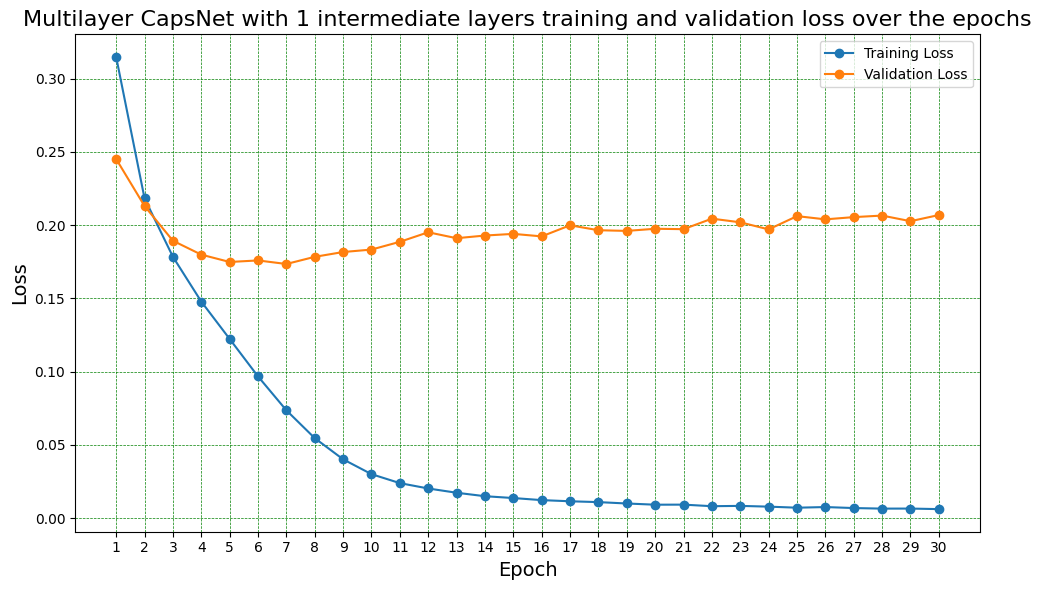

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 1 intermediate layers training and validation loss over the epochs')

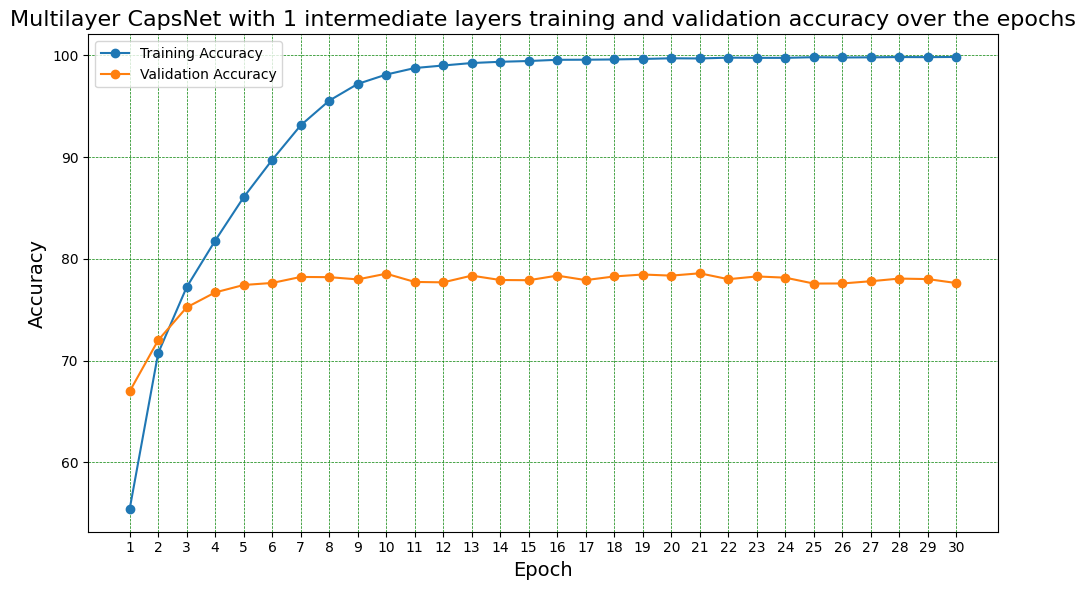

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 1 intermediate layers training and validation accuracy over the epochs')

## 2 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

batch_size=32

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter2_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=2)

multilayer_inter2_capsnet_cifar10_model.name = 'multilayer_inter2_capsnet_cifar10_model'
multilayer_inter2_capsnet_cifar10_model = multilayer_inter2_capsnet_cifar10_model.to(device)
multilayer_inter2_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAgg

In [ ]:
%%time
n_epochs = 30

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter2_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

01/22 08:41:01 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7425, Top 1 Acc=9.38, Top 5 Acc=68.75
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7425, Top 1 Acc=9.38, Top 5 Acc=68.75
01/22 08:41:12 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5355, Top 1 Acc=20.55, Top 5 Acc=68.28
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5355, Top 1 Acc=20.55, Top 5 Acc=68.28
01/22 08:41:22 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4919, Top 1 Acc=25.24, Top 5 Acc=75.24
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4919, Top 1 Acc=25.24, Top 5 Acc=75.24
01/22 08:41:33 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4687, Top 1 Acc=28.93, Top 5 Acc=79

KeyboardInterrupt: 

In [ ]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_multilayer_inter2_capsnet_cifar10_model_Epoch15_of_30.pt'

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter2_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device,
                                                                checkpoint_file=checkpoint_file)

Files already downloaded and verified
Files already downloaded and verified


01/22 11:16:30 PM | multilayer_inter2_capsnet_cifar10_model best accuracy=78.550 saved at: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/train/cifar10/Trained_multilayer_inter2_capsnet_cifar10_model_Epoch11_of_30.pt
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model best accuracy=78.550 saved at: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/train/cifar10/Trained_multilayer_inter2_capsnet_cifar10_model_Epoch11_of_30.pt


CPU times: user 1.38 s, sys: 290 ms, total: 1.67 s
Wall time: 4.82 s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter2_capsnet_cifar10_model_Epoch15_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

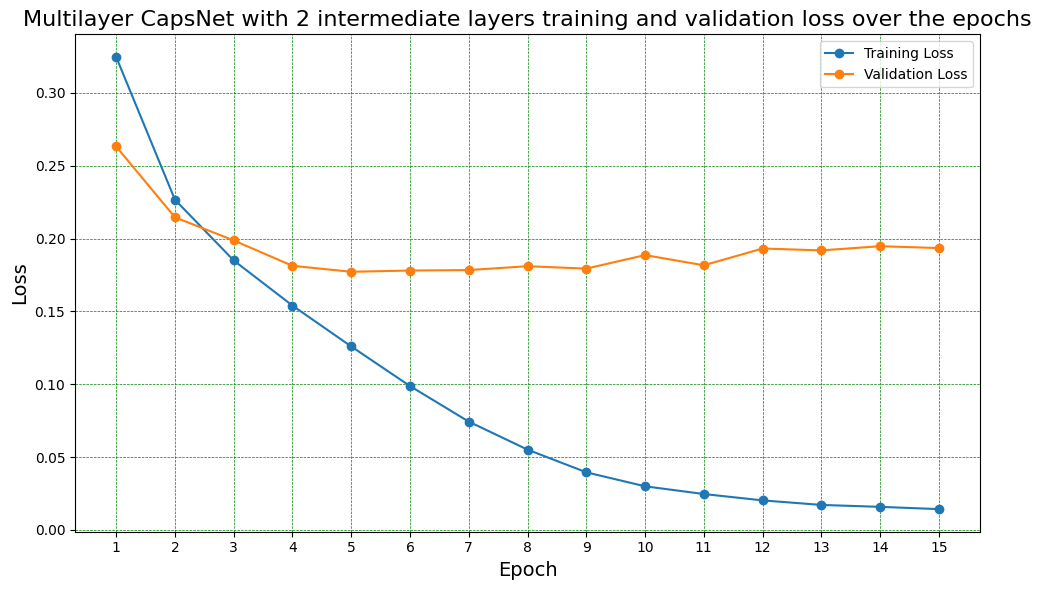

In [ ]:
utils.plot_line_chart(epoch_loss[:, :15], ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 2 intermediate layers training and validation loss over the epochs')

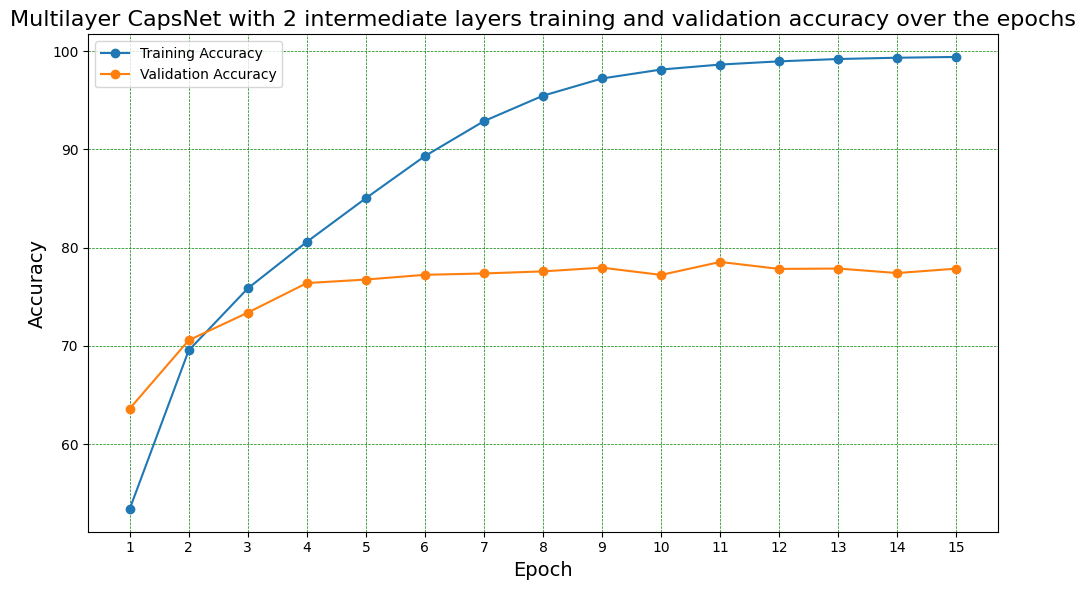

In [ ]:
utils.plot_line_chart(epoch_accuracy[:, :15], ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 2 intermediate layers training and validation accuracy over the epochs')

## 3 Intermediate Layered CapsNet

In [ ]:
multilayer_inter3_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=3)

multilayer_inter3_capsnet_cifar10_model.name = 'multilayer_inter3_capsnet_cifar10_model'
multilayer_inter3_capsnet_cifar10_model = multilayer_inter3_capsnet_cifar10_model.to(device)
multilayer_inter3_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
  )
 

In [ ]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter3_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

Files already downloaded and verified
Files already downloaded and verified


01/22 11:20:18 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7423, Top 1 Acc=18.75, Top 5 Acc=59.38
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7423, Top 1 Acc=18.75, Top 5 Acc=59.38
01/22 11:20:33 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5418, Top 1 Acc=23.01, Top 5 Acc=68.94
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5418, Top 1 Acc=23.01, Top 5 Acc=68.94
01/22 11:20:50 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4933, Top 1 Acc=28.51, Top 5 Acc=75.10
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4933, Top 1 Acc=28.51, Top 5 Acc=75.10
01/22 11:21:06 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4696, Top 1 Acc=31.60, Top 5 Acc=

CPU times: user 3h 15min 59s, sys: 5min 9s, total: 3h 21min 8s
Wall time: 3h 22min 51s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter3_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

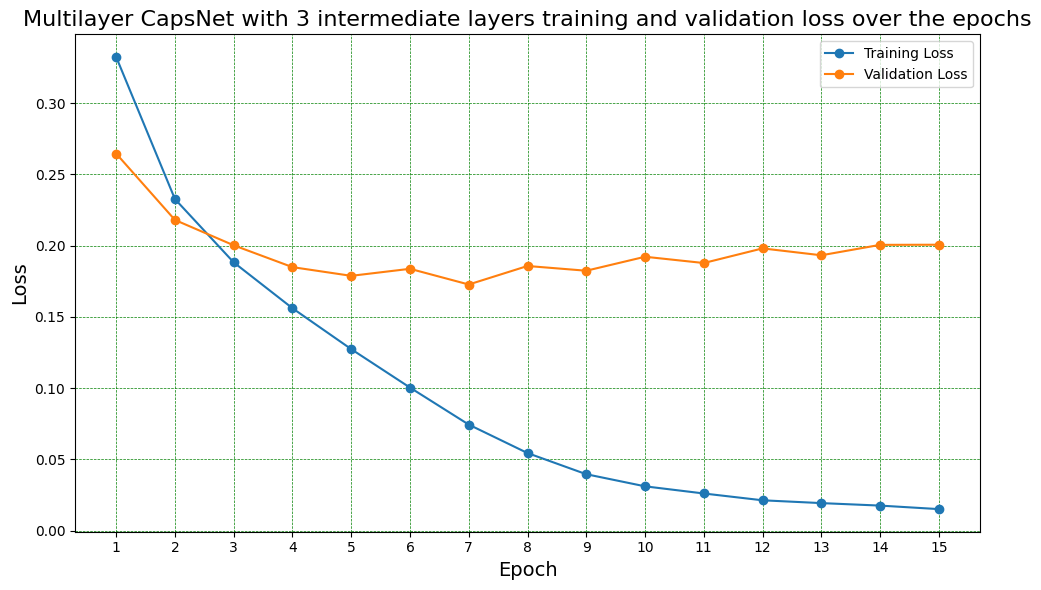

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 3 intermediate layers training and validation loss over the epochs')

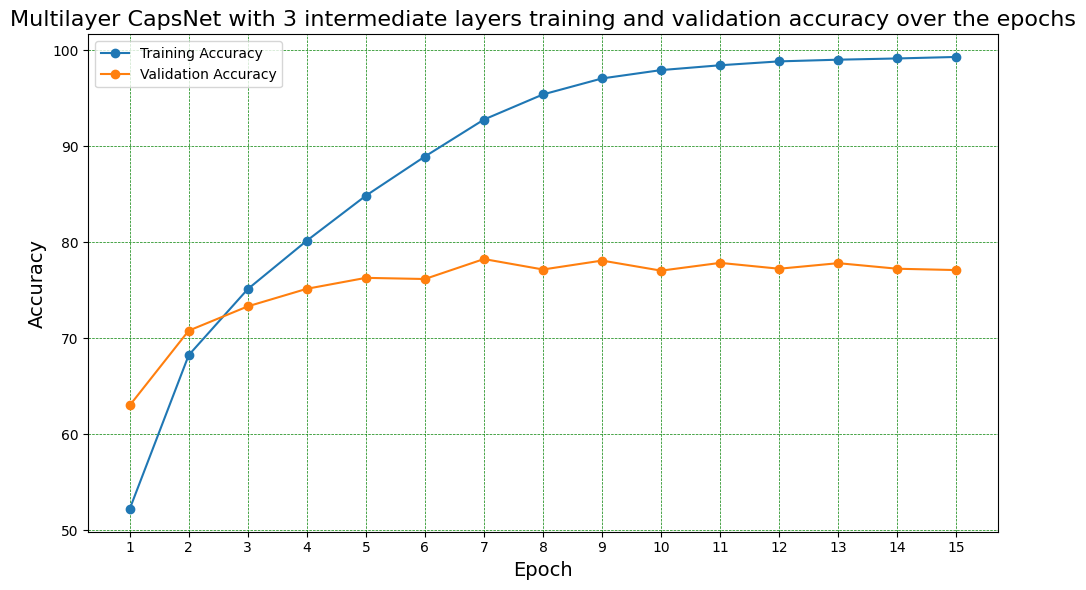

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 3 intermediate layers training and validation accuracy over the epochs')

## 4 Intermediate Layered CapsNet

In [ ]:
multilayer_inter4_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=4)

multilayer_inter4_capsnet_cifar10_model.name = 'multilayer_inter4_capsnet_cifar10_model'
multilayer_inter4_capsnet_cifar10_model = multilayer_inter4_capsnet_cifar10_model.to(device)
multilayer_inter4_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter4_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

Files already downloaded and verified
Files already downloaded and verified


01/23 04:23:31 AM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7416, Top 1 Acc=12.50, Top 5 Acc=65.62
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7416, Top 1 Acc=12.50, Top 5 Acc=65.62
01/23 04:23:40 AM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5699, Top 1 Acc=17.99, Top 5 Acc=63.07
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5699, Top 1 Acc=17.99, Top 5 Acc=63.07
01/23 04:23:49 AM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5185, Top 1 Acc=22.60, Top 5 Acc=71.11
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5185, Top 1 Acc=22.60, Top 5 Acc=71.11
01/23 04:23:59 AM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4934, Top 1 Acc=25.58, Top 5 Acc=

CPU times: user 1h 49min 1s, sys: 6min 3s, total: 1h 55min 4s
Wall time: 1h 56min 9s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter4_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

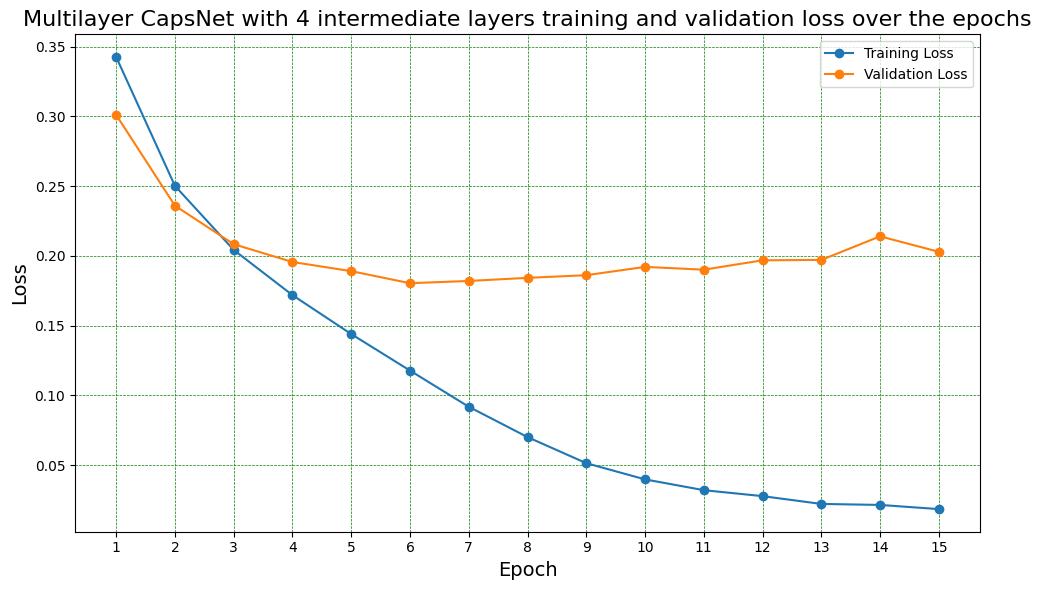

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 4 intermediate layers training and validation loss over the epochs')

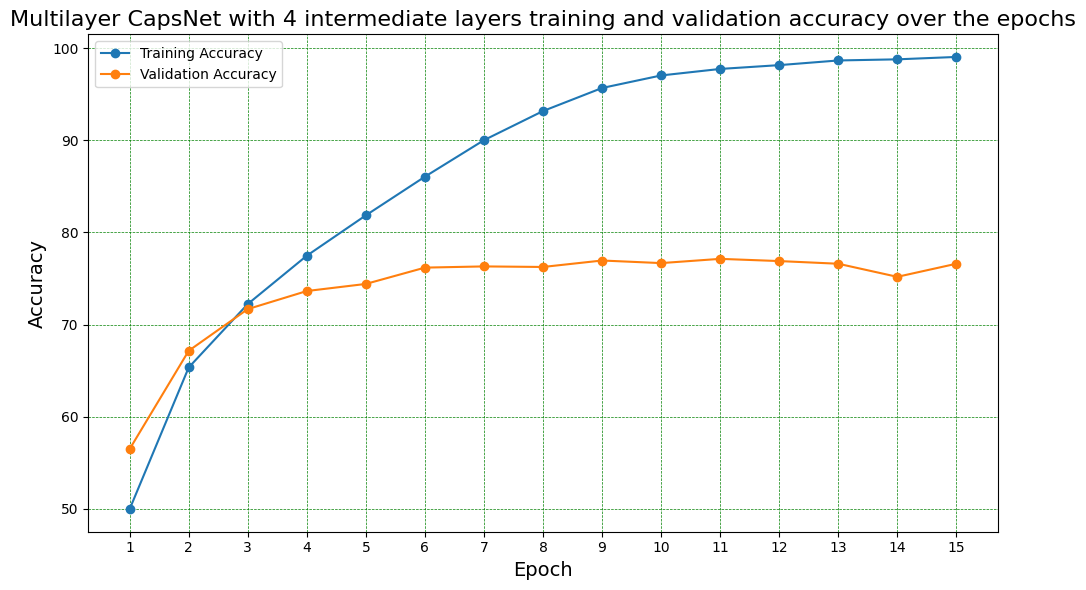

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 4 intermediate layers training and validation accuracy over the epochs')

## 5 Intermediate Layered CapsNet

In [ ]:
multilayer_inter5_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=5)

multilayer_inter5_capsnet_cifar10_model.name = 'multilayer_inter5_capsnet_cifar10_model'
multilayer_inter5_capsnet_cifar10_model = multilayer_inter5_capsnet_cifar10_model.to(device)
multilayer_inter5_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
%%time
n_epochs = 30
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter5_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

Files already downloaded and verified
Files already downloaded and verified


01/22 02:22:48 PM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7490, Top 1 Acc=6.25, Top 5 Acc=43.75
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7490, Top 1 Acc=6.25, Top 5 Acc=43.75
01/22 02:22:56 PM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5824, Top 1 Acc=16.76, Top 5 Acc=60.04
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5824, Top 1 Acc=16.76, Top 5 Acc=60.04
01/22 02:23:05 PM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5325, Top 1 Acc=21.73, Top 5 Acc=66.83
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5325, Top 1 Acc=21.73, Top 5 Acc=66.83
01/22 02:23:14 PM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5044, Top 1 Acc=25.84, Top 5 Acc=71

CPU times: user 3h 27min, sys: 12min 32s, total: 3h 39min 32s
Wall time: 3h 38min 58s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter5_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

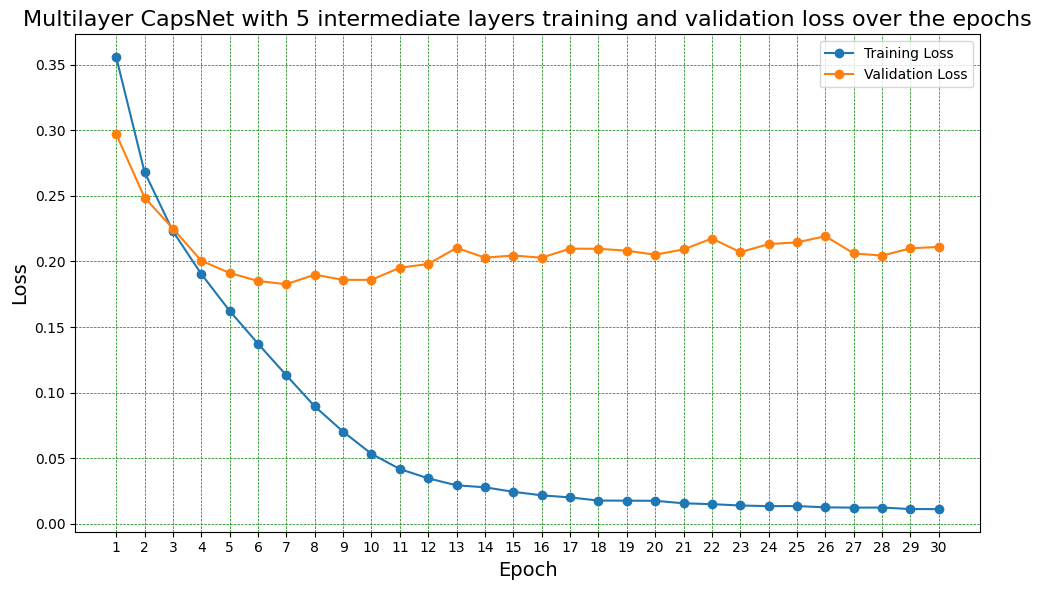

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 5 intermediate layers training and validation loss over the epochs')

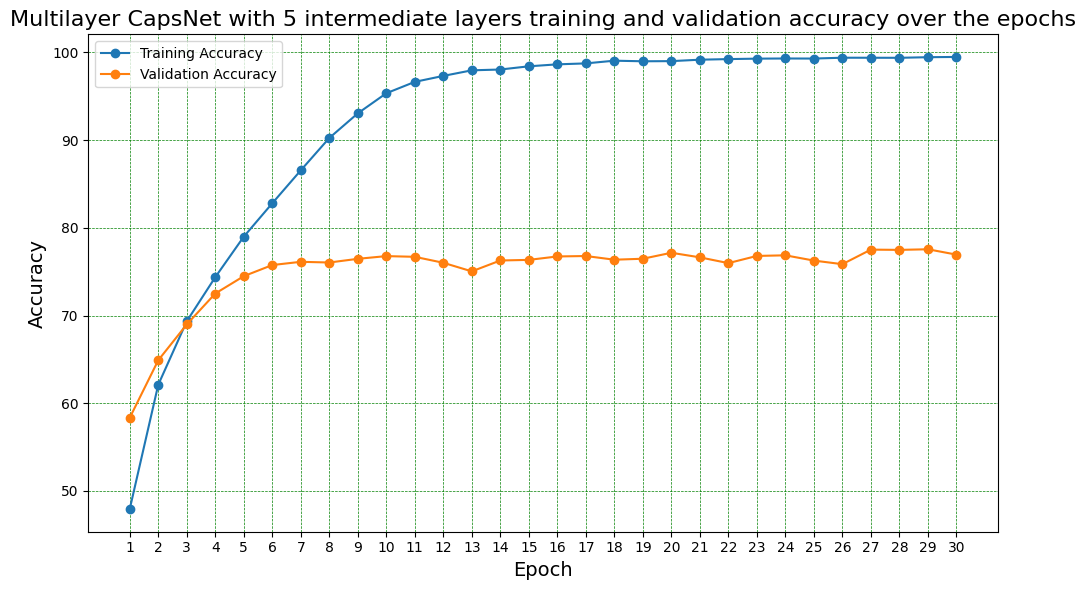

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 5 intermediate layers training and validation accuracy over the epochs')

## 6 Intermediate Layered CapsNet

In [ ]:
multilayer_inter6_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=6)

multilayer_inter6_capsnet_cifar10_model.name = 'multilayer_inter6_capsnet_cifar10_model'
multilayer_inter6_capsnet_cifar10_model = multilayer_inter6_capsnet_cifar10_model.to(device)
multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter6_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

100%|██████████| 170498071/170498071 [00:01<00:00, 104748639.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


01/23 12:57:33 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7453, Top 1 Acc=9.38, Top 5 Acc=62.50
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7453, Top 1 Acc=9.38, Top 5 Acc=62.50
01/23 12:57:43 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6166, Top 1 Acc=12.41, Top 5 Acc=58.24
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6166, Top 1 Acc=12.41, Top 5 Acc=58.24
01/23 12:57:53 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5512, Top 1 Acc=17.69, Top 5 Acc=67.21
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5512, Top 1 Acc=17.69, Top 5 Acc=67.21
01/23 12:58:02 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5201, Top 1 Acc=21.88, Top 5 Acc=71

CPU times: user 1h 58min 17s, sys: 6min 51s, total: 2h 5min 8s
Wall time: 2h 4min 53s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

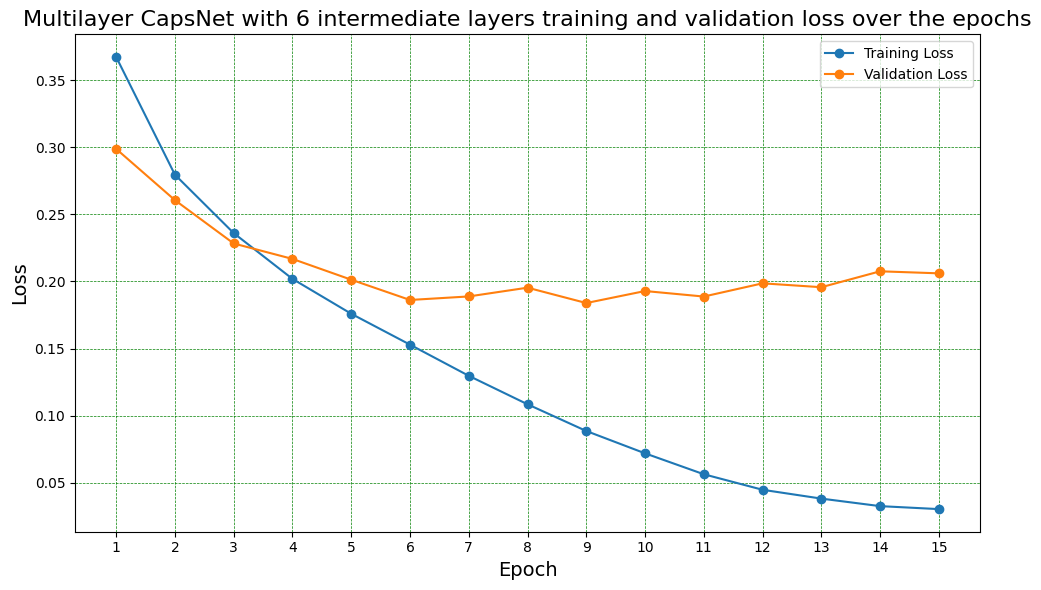

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 6 intermediate layers training and validation loss over the epochs')

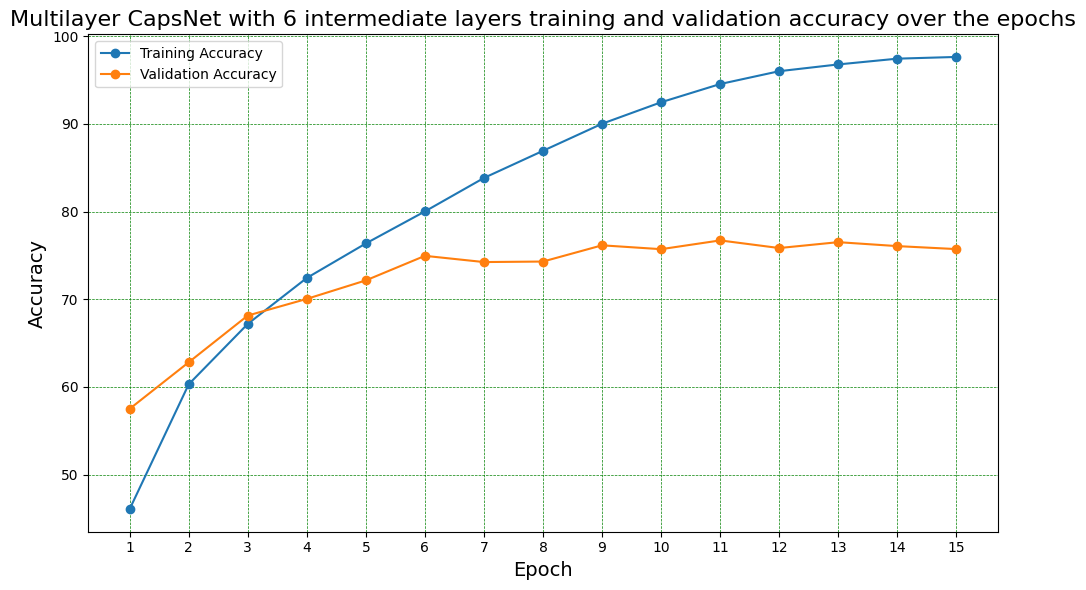

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 6 intermediate layers training and validation accuracy over the epochs')

## 7 Intermediate Layered CapsNet

In [ ]:
multilayer_inter7_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=7)

multilayer_inter7_capsnet_cifar10_model.name = 'multilayer_inter7_capsnet_cifar10_model'
multilayer_inter7_capsnet_cifar10_model = multilayer_inter7_capsnet_cifar10_model.to(device)
multilayer_inter7_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter7_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

Files already downloaded and verified
Files already downloaded and verified


01/23 03:03:39 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7513, Top 1 Acc=9.38, Top 5 Acc=56.25
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7513, Top 1 Acc=9.38, Top 5 Acc=56.25
01/23 03:03:50 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6393, Top 1 Acc=13.35, Top 5 Acc=55.21
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6393, Top 1 Acc=13.35, Top 5 Acc=55.21
01/23 03:04:01 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5632, Top 1 Acc=18.89, Top 5 Acc=63.41
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5632, Top 1 Acc=18.89, Top 5 Acc=63.41
01/23 03:04:12 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5286, Top 1 Acc=22.07, Top 5 Acc=68

CPU times: user 2h 14min 45s, sys: 7min 44s, total: 2h 22min 29s
Wall time: 2h 22min 5s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter7_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

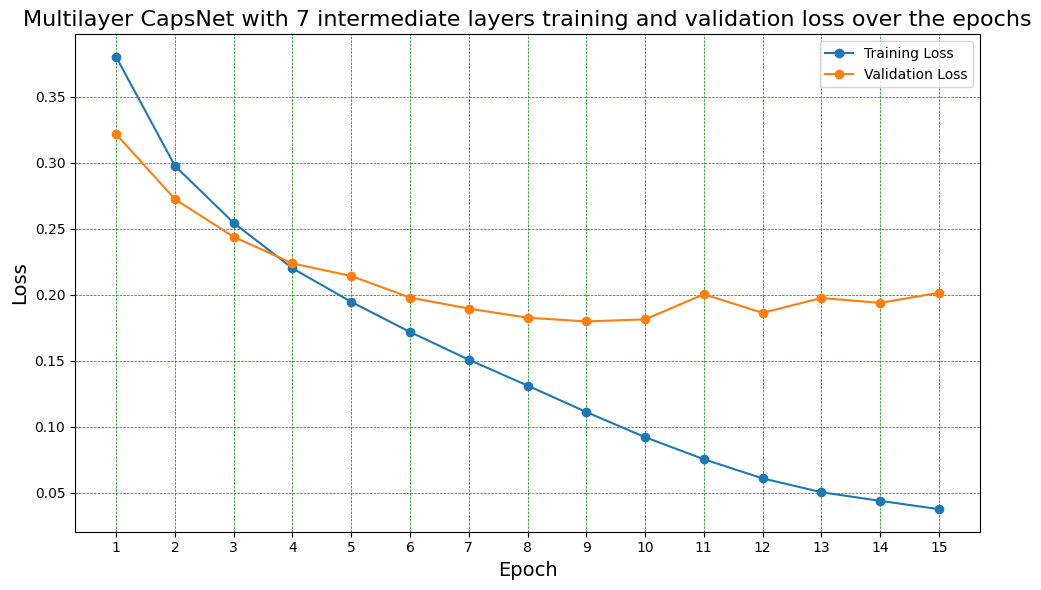

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 7 intermediate layers training and validation loss over the epochs')

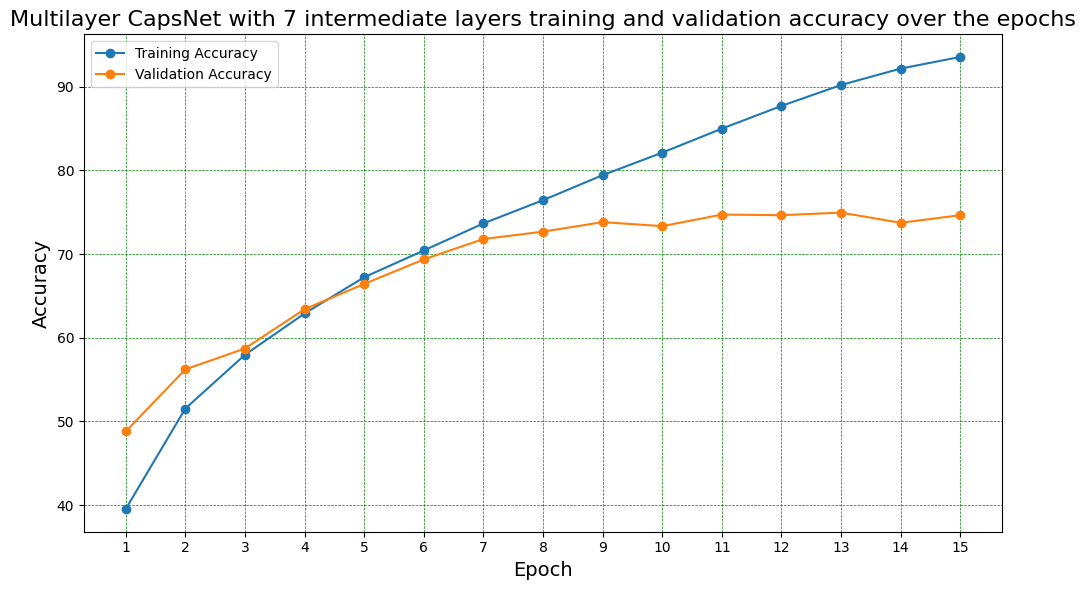

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 7 intermediate layers training and validation accuracy over the epochs')

## 8 Intermediate Layered CapsNet

In [ ]:
multilayer_inter8_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=8)

multilayer_inter8_capsnet_cifar10_model.name = 'multilayer_inter8_capsnet_cifar10_model'
multilayer_inter8_capsnet_cifar10_model = multilayer_inter8_capsnet_cifar10_model.to(device)
multilayer_inter8_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter8_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

Files already downloaded and verified
Files already downloaded and verified


01/23 05:28:36 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7519, Top 1 Acc=0.00, Top 5 Acc=37.50
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7519, Top 1 Acc=0.00, Top 5 Acc=37.50
01/23 05:28:48 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6648, Top 1 Acc=10.61, Top 5 Acc=53.79
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6648, Top 1 Acc=10.61, Top 5 Acc=53.79
01/23 05:29:01 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5848, Top 1 Acc=15.67, Top 5 Acc=61.25
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5848, Top 1 Acc=15.67, Top 5 Acc=61.25
01/23 05:29:14 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5501, Top 1 Acc=18.49, Top 5 Acc=66

CPU times: user 2h 31min 43s, sys: 8min 38s, total: 2h 40min 21s
Wall time: 2h 39min 55s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter8_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

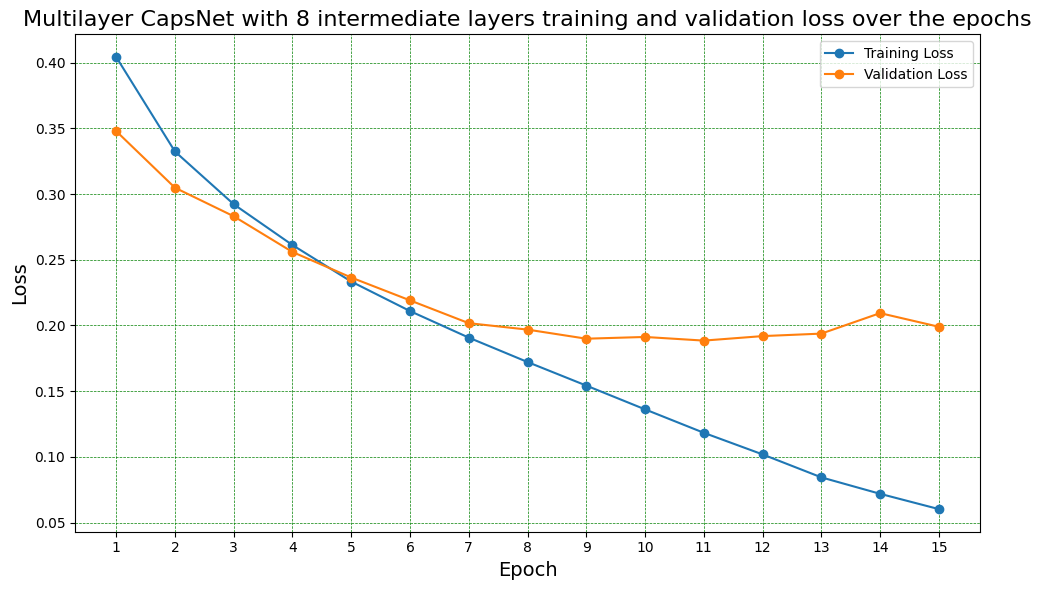

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 8 intermediate layers training and validation loss over the epochs')

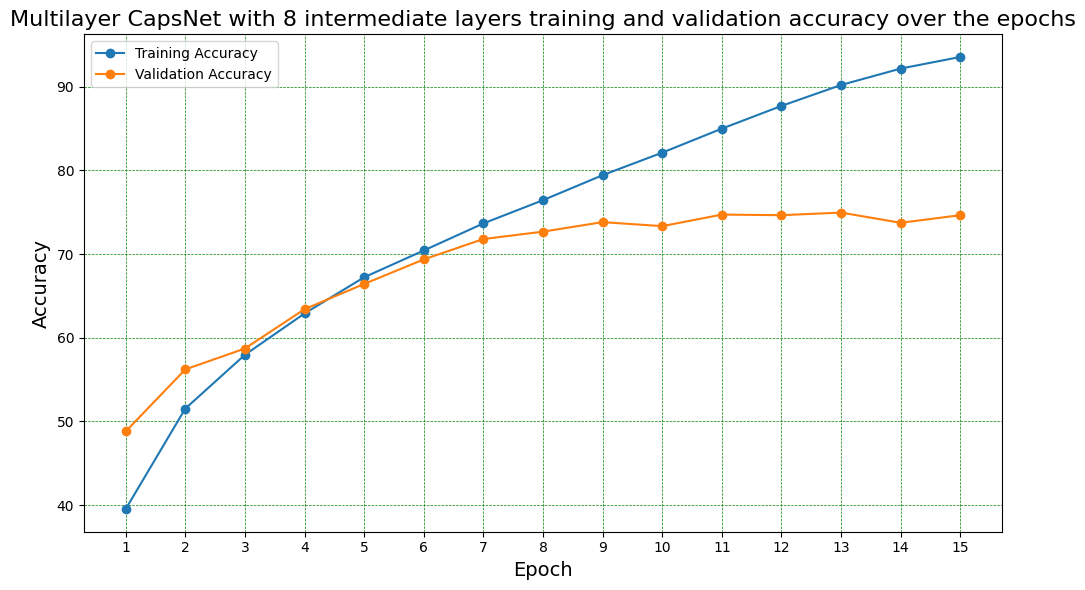

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 8 intermediate layers training and validation accuracy over the epochs')

## 9 Intermediate Layered CapsNet

In [ ]:
multilayer_inter9_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=9)

multilayer_inter9_capsnet_cifar10_model.name = 'multilayer_inter9_capsnet_cifar10_model'
multilayer_inter9_capsnet_cifar10_model = multilayer_inter9_capsnet_cifar10_model.to(device)
multilayer_inter9_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter9_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

Files already downloaded and verified
Files already downloaded and verified


01/23 08:26:44 PM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7534, Top 1 Acc=12.50, Top 5 Acc=59.38
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7534, Top 1 Acc=12.50, Top 5 Acc=59.38
01/23 08:26:58 PM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7019, Top 1 Acc=12.97, Top 5 Acc=53.31
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7019, Top 1 Acc=12.97, Top 5 Acc=53.31
01/23 08:27:12 PM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6138, Top 1 Acc=14.04, Top 5 Acc=56.68
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6138, Top 1 Acc=14.04, Top 5 Acc=56.68
01/23 08:27:26 PM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5756, Top 1 Acc=16.49, Top 5 Acc=

CPU times: user 2h 48min 56s, sys: 9min 34s, total: 2h 58min 30s
Wall time: 2h 58min


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter9_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

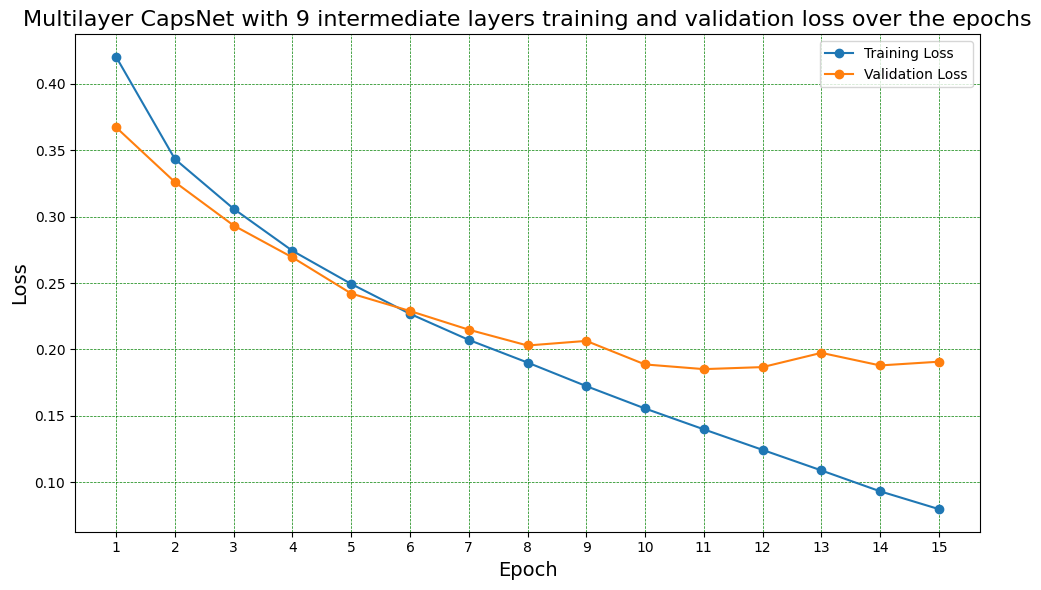

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 9 intermediate layers training and validation loss over the epochs')

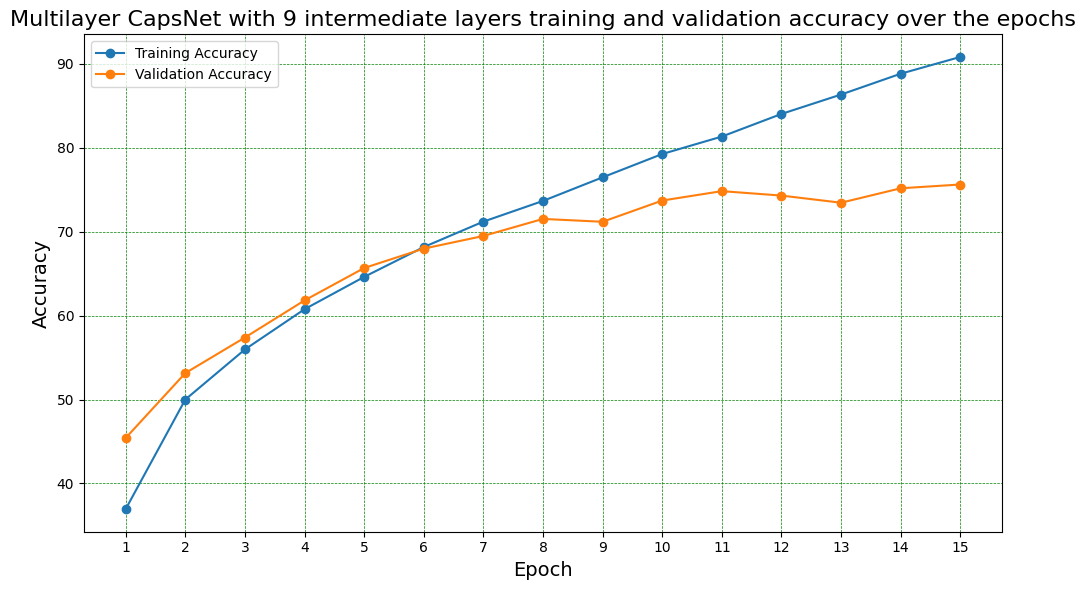

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 9 intermediate layers training and validation accuracy over the epochs')

In [ ]:
from google.colab import runtime
runtime.unassign()

## 10 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

batch_size=32
n_epochs=15
n_caps_layers=10

n_class=10
prim_caps_channels=16
prim_caps_dim=8

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:05<00:00, 29368754.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter10_capsnet_cifar10_model.name = 'multilayer_inter10_capsnet_cifar10_model'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter10_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

01/30 02:46:37 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7579, Top 1 Acc=6.25, Top 5 Acc=37.50
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7579, Top 1 Acc=6.25, Top 5 Acc=37.50
01/30 02:46:52 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7128, Top 1 Acc=10.42, Top 5 Acc=48.77
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7128, Top 1 Acc=10.42, Top 5 Acc=48.77
01/30 02:47:10 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6255, Top 1 Acc=12.40, Top 5 Acc=54.09
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6255, Top 1 Acc=12.40, Top 5 Acc=54.09
01/30 02:47:25 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5881, Top 1 Acc=13.79, Top 5

CPU times: user 3h 1min 41s, sys: 11min 48s, total: 3h 13min 29s
Wall time: 3h 15min 29s


In [ ]:
from google.colab import runtime
runtime.unassign()

Checkpoint restart

In [ ]:
%%time
n_epochs = 30
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt'

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter10_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device,
                                                                checkpoint_file=checkpoint_file)

100%|██████████| 170498071/170498071 [00:01<00:00, 91333369.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


01/22 12:54:20 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.1371, Top 1 Acc=84.38, Top 5 Acc=96.88
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.1371, Top 1 Acc=84.38, Top 5 Acc=96.88
01/22 12:54:35 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.0948, Top 1 Acc=88.64, Top 5 Acc=98.77
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.0948, Top 1 Acc=88.64, Top 5 Acc=98.77
01/22 12:54:51 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.1013, Top 1 Acc=87.50, Top 5 Acc=99.04
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.1013, Top 1 Acc=87.50, Top 5 Acc=99.04
01/22 12:55:06 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(96/1563), Loss=0.1000, Top 1 Acc=87.

CPU times: user 3h 6min 23s, sys: 10min 42s, total: 3h 17min 6s
Wall time: 3h 16min 43s


Model training with 50% pruned

In [ ]:
clear_gpu_memory()

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=10
prim_caps_channels=16
prim_caps_dim=8

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
best_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_50pc_base_capsnet_cifar10_model.pt')

best_50pc_base_capsnet_cifar10_model_stdict = best_50pc_base_capsnet_cifar10_model['model_state_dict']

multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

pruned_50pc_multilayer_inter10_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(multilayer_inter10_capsnet_cifar10_model,
                                                                                               best_50pc_base_capsnet_cifar10_model_stdict,
                                                                                               model_conv_config,
                                                                                               n_class,
                                                                                               n_caps_layers,
                                                                                               prim_caps_dim,
                                                                                               base_capsnet_stdict=True)

pruned_50pc_multilayer_inter10_capsnet_cifar10_model.name = 'pruned_50pc_multilayer_inter10_capsnet_cifar10_model'
pruned_50pc_multilayer_inter10_capsnet_cifar10_model = pruned_50pc_multilayer_inter10_capsnet_cifar10_model.to(device)
pruned_50pc_multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  pruned_50pc_multilayer_inter10_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/05 12:30:25 AM | pruned_50pc_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=12.50, Top 5 Acc=46.88
INFO:capsnet:pruned_50pc_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=12.50, Top 5 Acc=46.88
02/05 12:30:38 AM | pruned_50pc_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6670, Top 1 Acc=12.22, Top 5 Acc=50.19
INFO:capsnet:pruned_50pc_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6670, Top 1 Acc=12.22, Top 5 Acc=50.19
02/05 12:30:51 AM | pruned_50pc_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5773, Top 1 Acc=17.36, Top 5 Acc=61.59
INFO:capsnet:pruned_50pc_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5773, Top 1 Acc=17.36, Top 5 Acc=61.59
02/05 12:31:04 AM | pruned_50pc_multilayer_inter10_capsnet_cifa

KeyboardInterrupt: 

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

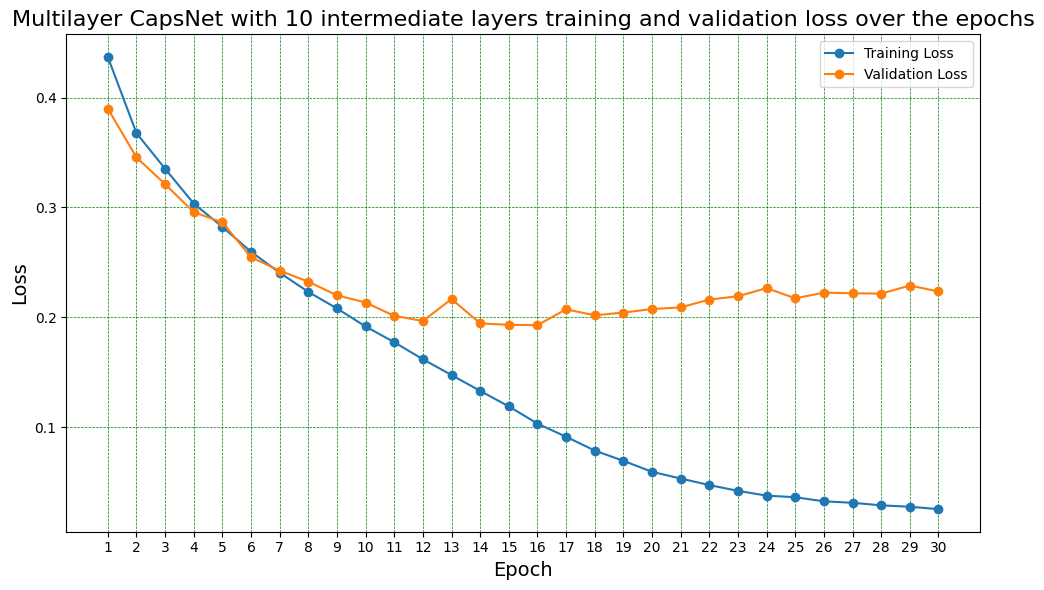

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 10 intermediate layers training and validation loss over the epochs')

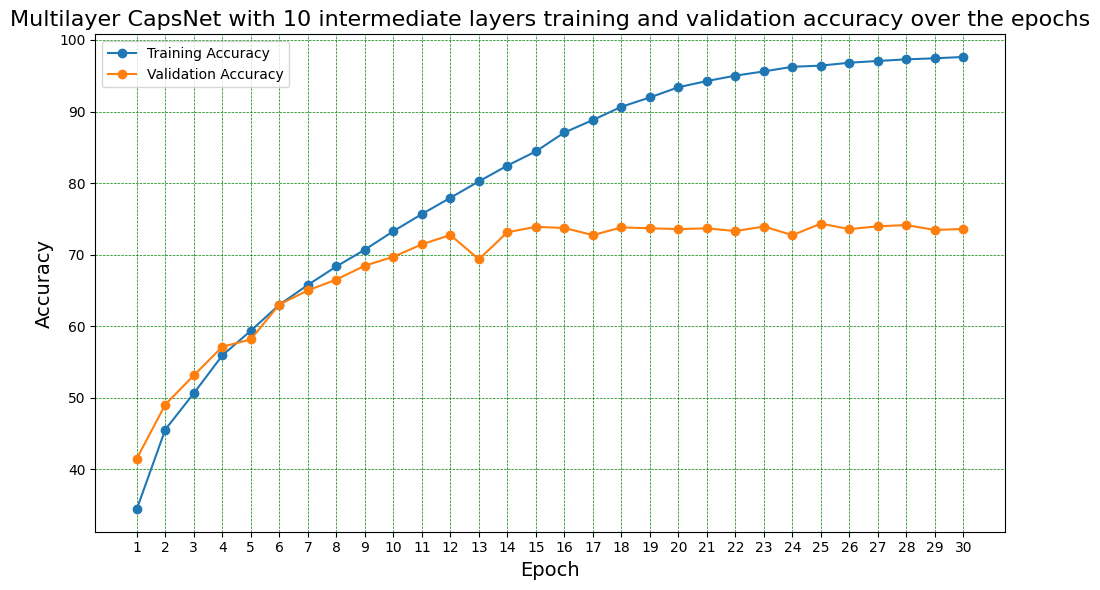

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 10 intermediate layers training and validation accuracy over the epochs')

## Plots for Base and All Multilayer CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

base_capsnet_cifar10_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter1_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter1_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter2_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter2_capsnet_cifar10_model_Epoch15_of_30.pt')
multilayer_capsnet_inter3_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter3_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter4_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter4_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter5_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter5_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter6_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter7_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter7_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter8_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter8_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter9_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter9_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter10_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch30_of_30.pt')

In [ ]:
models = [base_capsnet_cifar10_model_data,
          multilayer_capsnet_inter1_model_data,
          multilayer_capsnet_inter2_model_data,
          multilayer_capsnet_inter3_model_data,
          multilayer_capsnet_inter4_model_data,
          multilayer_capsnet_inter5_model_data,
          multilayer_capsnet_inter6_model_data,
          multilayer_capsnet_inter7_model_data,
          multilayer_capsnet_inter8_model_data,
          multilayer_capsnet_inter9_model_data,
          multilayer_capsnet_inter10_model_data]

legends = ['Base',
           '1 InterLayer',
           '2 InterLayers',
           '3 InterLayers',
           '4 InterLayers',
           '5 InterLayers',
           '6 InterLayers',
           '7 InterLayers',
           '8 InterLayers',
           '9 InterLayers',
           '10 InterLayers']

n_epochs = 15

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][:,:15][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][:, :15][1]

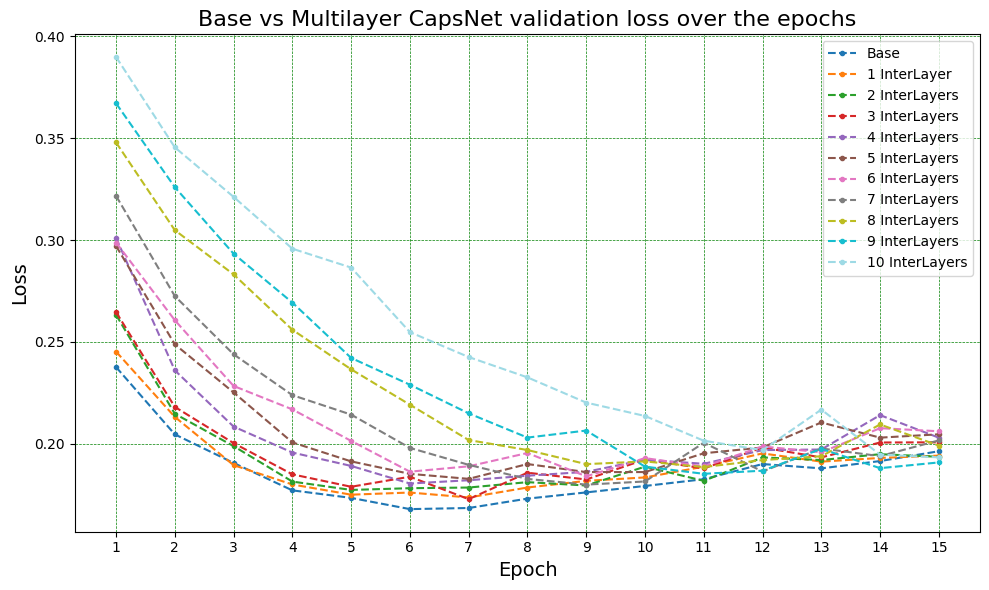

In [ ]:
utils.plot_line_chart(epoch_losses, legends, 'Epoch', 'Loss',
                      'Base vs Multilayer CapsNet validation loss over the epochs', marker='.', line='--')

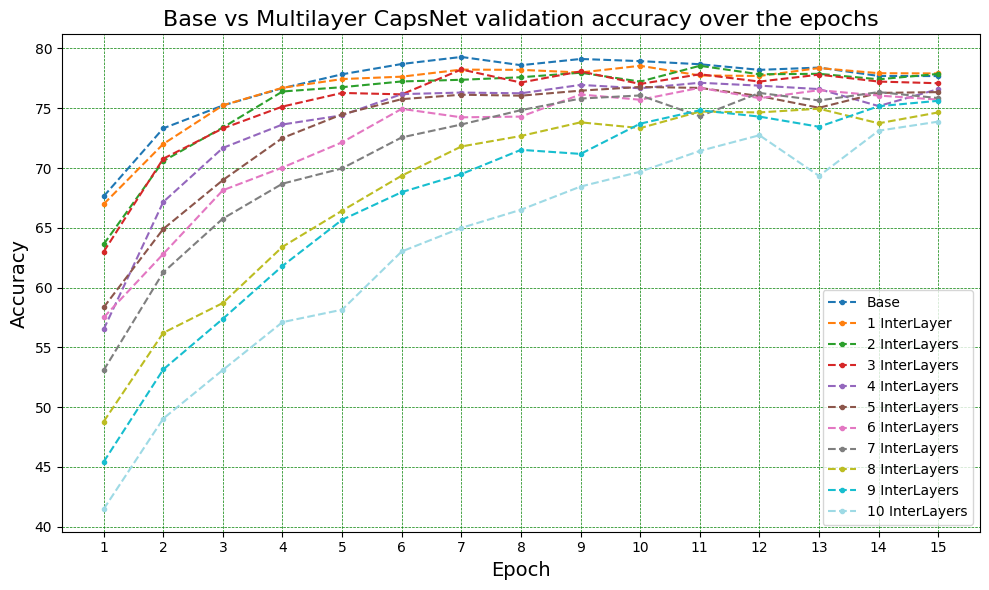

In [ ]:
utils.plot_line_chart(epoch_accuracies, legends, 'Epoch', 'Accuracy',
                      'Base vs Multilayer CapsNet validation accuracy over the epochs', marker='.', line='--')